In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from scipy import stats
from itertools import product
import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm

import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import warnings; warnings.simplefilter('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.rcParams["figure.figsize"] = (7,4)

## <center> Прогнозирование с xgboost

### Подготовка временного ряда и формирование признаков

In [36]:
data_customer = pd.read_csv("customers.tsv", sep="\t")
data_sales = pd.read_csv("sales.tsv", sep="\t")

In [38]:
data_sales["day"] = 1;
data_sales["date"] = pd.to_datetime(data_sales[["year", "month", "day"]]);
data_customer["day"] = 1;
data_customer["date"] = pd.to_datetime(data_customer[["year", "month", "day"]]);

In [50]:
data_customer_ac = data_customer[data_customer["ira"] == "AC"][["date", "amount_of_customers"]].groupby("date").sum()
data_15_ac = data_sales[(data_sales["sku_id"] ==  "sku #15") & (data_sales["ira"] ==  "AC")][["date", "month", "day", "year", "volume", "price"]]
data_15_ac["demand"] = data_customer_ac.values[:30]
data_15_ac = data_15_ac.set_index("date")
df = data_15_ac
df.head()

,month,day,year,volume,price,demand
date,,,,,,
2017-01-01,1,1,2017,8028.0,1.221336,54396.0
2017-02-01,2,1,2017,9714.0,1.223776,54299.0
2017-03-01,3,1,2017,10614.0,1.228686,65163.0
2017-04-01,4,1,2017,11646.0,1.240506,73088.0
2017-05-01,5,1,2017,8700.0,1.268904,76452.0


In [56]:
X = df[['month','year', 'price','demand']];

### Одной функцией

In [65]:
def create_features(ira, sku, label="volume"):
    data_customer_ac = data_customer[data_customer["ira"] == ira][["date", "amount_of_customers"]].groupby("date").sum()
    data_15_ac = data_sales[(data_sales["sku_id"] ==  sku) & (data_sales["ira"] ==  ira)][["date", "month", "day", "year", "volume", "price"]]
    data_15_ac["demand"] = data_customer_ac.values[:data_15_ac.shape[0]]
    data_15_ac = data_15_ac.set_index("date")
    df = data_15_ac
    
    X = df[['month','year', 'price','demand']]
    if label:
        y = df[label]
        return X, y
    return X

In [519]:
def get_demands(ira, sku):
    data_customer_ac = data_customer[data_customer["ira"] == ira][["date", "amount_of_customers"]].groupby("date").sum()
    return data_customer_ac.values[-3:]

In [162]:
X, y = create_features("AC", "sku #16", "volume")

### test train

In [767]:
split_date = '2019-01-01'
X_train = X.loc[X.index <= split_date].copy().values
X_test = X.loc[X.index > split_date].copy().values
y_train = y.loc[y.index <= split_date].copy().values
y_test = y.loc[y.index > split_date].copy().values

### create model

In [779]:
reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, reg_lambda=0, max_depth=12, objective='reg:squarederror', colsample_bylevel=0.5,
       colsample_bynode=0.5, colsample_bytree=0.5)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, 
        verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bynode=0.5, colsample_bytree=0.5, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

### Значимость признаков

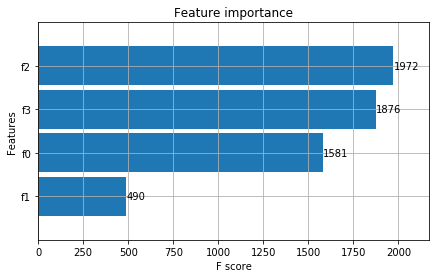

In [780]:
_ = plot_importance(reg, height=0.9)

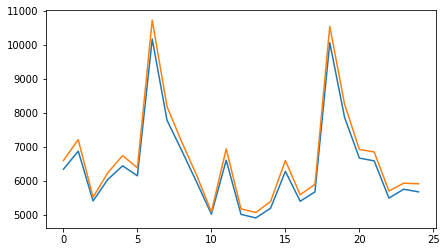

In [781]:
plt.plot(reg.predict(X_train))
plt.plot(y_train)
plt.show()


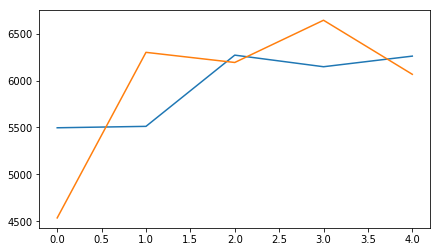

In [782]:
plt.plot(reg.predict(X_test))
plt.plot(y_test)
plt.show()


In [776]:
def metrics(x, y):
    return mean_absolute_error(x, y) / (1/2*(np.mean(x) + np.mean(y)))

In [777]:
# нужно настроить параметры бустера

In [778]:
metrics(y_test, reg.predict(X_test))

0.4167487181441887

### Попробуем эту модель для других sku

In [485]:
def get_metrics_value(ira, sku):
    try:
        
        X, y = create_features(ira, sku, "volume")
        X_train = X.loc[X.index <= split_date].copy().values
        X_test = X.loc[X.index > split_date].copy().values
        y_train = y.loc[y.index <= split_date].copy().values
        y_test = y.loc[y.index > split_date].copy().values
        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=50, 
            verbose=False)
        return metrics(y_test, reg.predict(X_test))
    except:
        return ["Problems", ira, sku]

In [823]:
get_metrics_value("AC", "sku #15")

0.23746424616121498

In [828]:
sku_arr = list(data_sales["sku_id"].unique());
ira_arr = list(data_sales["ira"].unique());

In [509]:
out = []
for ira in ira_arr:
    for sku in sku_arr:
        out.append(get_metrics_value(ira, sku))

### Средняя ошибка для всех рядов, которые прогнозируются этой моделью

In [477]:
np.mean(list(filter(lambda x: type(x) != list, out)))

0.31544235430130674

### Будем записывать результаты

In [827]:
df_res = pd.DataFrame(columns=['year', 'month', 'ira', "sku_id", "volume"])
df_res

,year,month,ira,sku_id,volume


### Получаем прогноз

In [783]:
def get_forecast(ira, sku):
    X_train, y_train = create_features(ira, sku, "volume")
    demands = get_demands(ira, sku)
    X_train = X_train.values
    y_train = y_train.values
    X_test = [[i+7, 2019, X_train[-1][2], demands[i, 0]] for i in range(3)]
    X_test = np.array(X_test)
    out_list = []
    for i in range(3):
        reg.fit(X_train, y_train, eval_set=[(X_train, y_train)], early_stopping_rounds=50, verbose=False)
        y_new = reg.predict([X_test[i]])[0]
        out_list.append(y_new)
        X_train = np.concatenate((X_train, np.array([X_test[i]])))
        y_train = np.concatenate((y_train, np.array([y_new])))
    return out_list
        
    

In [784]:
get_forecast("AC", "sku #16")

[8986.224, 9034.359, 8255.545]

In [829]:
out = []
for ira in ira_arr:
    for sku in sku_arr:
        m = get_metrics_value(ira, sku)
        print(ira, sku, m)
        if type(m) != list:
            forecast = get_forecast(ira, sku)
            df_curr = pd.DataFrame([[2019, 7, ira, sku, forecast[0]],
                                    [2019, 8, ira, sku, forecast[1]],
                                    [2019, 9, ira, sku, forecast[2]]], 
                                   columns=['year', 'month', 'ira', "sku_id", "volume"])
            df_res = df_res.append(df_curr)
            ind = sku_arr.index(sku)
            del sku_arr[ind] 

AC sku #79 0.12996029247334223
AC sku #16 0.08469337051357706
AC sku #28 0.09084702317399762
AC sku #31 0.7611646316015297
AC sku #38 0.09573024724693882
AC sku #46 0.30065939518934487
AC sku #49 0.03368947585648988
AC sku #67 0.7567835110911205
AC sku #73 0.15841428403450578
AC sku #34 ['Problems', 'AC', 'sku #34']
AC sku #37 ['Problems', 'AC', 'sku #37']
AC sku #27 ['Problems', 'AC', 'sku #27']
AC sku #43 ['Problems', 'AC', 'sku #43']
AC sku #44 ['Problems', 'AC', 'sku #44']
AC sku #72 ['Problems', 'AC', 'sku #72']
AC sku #81 ['Problems', 'AC', 'sku #81']
AC sku #82 ['Problems', 'AC', 'sku #82']
AC sku #83 ['Problems', 'AC', 'sku #83']
AC sku #84 ['Problems', 'AC', 'sku #84']
AC sku #7 ['Problems', 'AC', 'sku #7']
AC sku #11 ['Problems', 'AC', 'sku #11']
AC sku #17 ['Problems', 'AC', 'sku #17']
AC sku #3 ['Problems', 'AC', 'sku #3']
AC sku #5 ['Problems', 'AC', 'sku #5']
AC sku #94 0.41535081802252727
AC sku #76 0.2986722219171563
AC sku #97 0.34927150422946956
AC sku #55 ['Problems'

In [832]:
df_res.shape

(63, 5)

### Отдельно для Village,  так как там нет данных по спросу

In [834]:
def create_features_vl(ira, sku, label="volume"):
    data_customer_ac = data_customer[data_customer["ira"] == ira][["date", "amount_of_customers"]].groupby("date").sum()
    data_15_ac = data_sales[(data_sales["sku_id"] ==  sku) & (data_sales["ira"] ==  ira)][["date", "month", "day", "year", "volume", "price"]]
    data_15_ac = data_15_ac.set_index("date")
    df = data_15_ac
    X = df[['month','year', 'price']]
    if label:
        y = df[label]
        return X, y
    return X

In [838]:
def get_metrics_value_vl(ira, sku):
    try:    
        X, y = create_features_vl(ira, sku, "volume")
        X_train = X.loc[X.index <= split_date].copy().values
        X_test = X.loc[X.index > split_date].copy().values
        y_train = y.loc[y.index <= split_date].copy().values
        y_test = y.loc[y.index > split_date].copy().values
        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=50, 
            verbose=False)
        return metrics(y_test, reg.predict(X_test))
    except:
        return ["Problems", ira, sku]

In [836]:
def get_forecast_vl(ira, sku):
    X_train, y_train = create_features_vl(ira, sku, "volume")
    X_train = X_train.values
    y_train = y_train.values
    X_test = [[i+7, 2019, X_train[-1][2]] for i in range(3)]
    X_test = np.array(X_test)
    out_list = []
    for i in range(3):
        reg.fit(X_train, y_train, eval_set=[(X_train, y_train)], early_stopping_rounds=50, verbose=False)
        y_new = reg.predict([X_test[i]])[0]
        out_list.append(y_new)
        X_train = np.concatenate((X_train, np.array([X_test[i]])))
        y_train = np.concatenate((y_train, np.array([y_new])))
    return out_list

In [840]:
for sku in list(data_sales["sku_id"].unique()):
    m = get_metrics_value_vl("VL", sku)
    print(ira, sku, m)
    if type(m) != list:
        forecast = get_forecast_vl("VL", sku)
        df_curr = pd.DataFrame([[2019, 7, ira, sku, forecast[0]],
                                [2019, 8, ira, sku, forecast[1]],
                                [2019, 9, ira, sku, forecast[2]]], 
                                columns=['year', 'month', 'ira', "sku_id", "volume"])
        df_res = df_res.append(df_curr)

VL sku #79 ['Problems', 'VL', 'sku #79']
VL sku #15 ['Problems', 'VL', 'sku #15']
VL sku #16 ['Problems', 'VL', 'sku #16']
VL sku #22 ['Problems', 'VL', 'sku #22']
VL sku #28 ['Problems', 'VL', 'sku #28']
VL sku #30 0.06632905730985976
VL sku #31 ['Problems', 'VL', 'sku #31']
VL sku #33 ['Problems', 'VL', 'sku #33']
VL sku #38 ['Problems', 'VL', 'sku #38']
VL sku #41 ['Problems', 'VL', 'sku #41']
VL sku #46 0.15123682550006537
VL sku #48 ['Problems', 'VL', 'sku #48']
VL sku #49 ['Problems', 'VL', 'sku #49']
VL sku #42 ['Problems', 'VL', 'sku #42']
VL sku #67 ['Problems', 'VL', 'sku #67']
VL sku #25 0.13850717424142564
VL sku #73 0.0906139119822573
VL sku #78 ['Problems', 'VL', 'sku #78']
VL sku #34 ['Problems', 'VL', 'sku #34']
VL sku #37 ['Problems', 'VL', 'sku #37']
VL sku #27 ['Problems', 'VL', 'sku #27']
VL sku #43 ['Problems', 'VL', 'sku #43']
VL sku #44 ['Problems', 'VL', 'sku #44']
VL sku #72 ['Problems', 'VL', 'sku #72']
VL sku #81 ['Problems', 'VL', 'sku #81']
VL sku #82 ['Pro

In [848]:
df_res.to_csv('solution.tsv',sep='\t')

# <center> Оптимальная цена

### Рассмотрим какой-нибудь товар

In [794]:
ira = "AC"
sku = "sku #22"
X_train, y_train = create_features(ira, sku, "volume")

In [803]:
price = X_train.values[-1][2]

In [807]:
prices = [price - i / 10 for i in range(50, 1, -1)] + [price + i/10 for i in range(1, 50, 1)]

In [809]:
prices;

In [810]:
def get_forecast1(ira, sku, price):
    X_train, y_train = create_features(ira, sku, "volume")
    demands = get_demands(ira, sku)
    X_train = X_train.values
    y_train = y_train.values
    X_test = [[i+7, 2019, price, demands[i, 0]] for i in range(3)]
    X_test = np.array(X_test)
    out_list = []
    for i in range(3):
        reg.fit(X_train, y_train, eval_set=[(X_train, y_train)], early_stopping_rounds=50, verbose=False)
        y_new = reg.predict([X_test[i]])[0]
        out_list.append(y_new)
        X_train = np.concatenate((X_train, np.array([X_test[i]])))
        y_train = np.concatenate((y_train, np.array([y_new])))
    return out_list
        

In [816]:
s = 0
p = price
for i in prices:
    f = get_forecast1(ira, sku, i)
    if sum(f) > s:
        s = sum(f)
        p = i

In [817]:
sum([1,2,3])

6

In [818]:
p

2.112236710130382